Unified preprocessing pipeline for Tox21:
- Loads Tox21 dataset (SMILES + labels)
- Creates scaffold-based train/val/test splits
- Exports:
    - Graph datasets (for GNNs, PyTorch Geometric)
    - Molecular-level descriptors/fingerprints (for baseline ML)
    - Split metadata (so both use identical molecules)

In [1]:
# import necessary libraries

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
import torch
from torch_geometric.data import Data
import deepchem as dc

c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  import torch_geometric.typing
c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  import torch_geometric.typing
c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  import torch_geometric.typing
c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/

In [2]:
# set random seed for reproducibility

np.random.seed(42)
torch.manual_seed(42)
os.makedirs("tox21_processed", exist_ok=True)

In [3]:
print("📥 Loading Tox21 dataset...")
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer="Raw", data_dir=".", save_dir=".")
train_dataset, valid_dataset, test_dataset = datasets

# print(type(train_dataset))


📥 Loading Tox21 dataset...


In [4]:
# convert datasets to pandas DataFrames for easier manipulation
train_df = train_dataset.to_dataframe()
valid_df = valid_dataset.to_dataframe()
test_df = test_dataset.to_dataframe()

# map tasks to column names such as tasks[0] is y1 column, replace it with tasks[0]
for i, task in enumerate(tasks):
    train_df.rename(columns={f'y{i+1}': task}, inplace=True)
    valid_df.rename(columns={f'y{i+1}': task}, inplace=True)
    test_df.rename(columns={f'y{i+1}': task}, inplace=True)

# save raw data to CSV files
train_df.to_csv("tox21_processed/train_raw.csv", index=False)
valid_df.to_csv("tox21_processed/valid_raw.csv", index=False)
test_df.to_csv("tox21_processed/test_raw.csv", index=False)

In [5]:
# do some basic EDA
print(f"Number of tasks: {len(tasks)}")
print(f"Tasks: {tasks}")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")
print("Sample data:")

print("✅ Data loading and initial processing complete.")
train_df.head()


Number of tasks: 12
Tasks: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Training set size: 6258
Validation set size: 782
Test set size: 783
Sample data:
✅ Data loading and initial processing complete.


,X,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,...,w4,w5,w6,w7,w8,w9,w10,w11,w12,ids
0,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.045464,1.145758,1.056077,1.025581,1.172887,1.035424,1.055832,1.174908,1.052945,CC(O)(P(=O)(O)O)P(=O)(O)O
1,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.045464,1.145758,1.056077,1.025581,0.000000,1.035424,1.055832,1.174908,1.052945,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.045464,1.145758,1.056077,1.025581,1.172887,1.035424,1.055832,0.000000,1.052945,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.172887,0.000000,1.055832,0.000000,0.000000,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.045464,1.145758,1.056077,1.025581,1.172887,1.035424,1.055832,1.174908,1.052945,CC(C)COC(=O)C(C)C


Missing values in training set:
X                0
NR-AR            0
NR-AR-LBD        0
NR-AhR           0
NR-Aromatase     0
NR-ER            0
NR-ER-LBD        0
NR-PPAR-gamma    0
SR-ARE           0
SR-ATAD5         0
SR-HSE           0
SR-MMP           0
SR-p53           0
w1               0
w2               0
w3               0
w4               0
w5               0
w6               0
w7               0
w8               0
w9               0
w10              0
w11              0
w12              0
ids              0
dtype: int64
Missing values in validation set:
X                0
NR-AR            0
NR-AR-LBD        0
NR-AhR           0
NR-Aromatase     0
NR-ER            0
NR-ER-LBD        0
NR-PPAR-gamma    0
SR-ARE           0
SR-ATAD5         0
SR-HSE           0
SR-MMP           0
SR-p53           0
w1               0
w2               0
w3               0
w4               0
w5               0
w6               0
w7               0
w8               0
w9               0
w10      

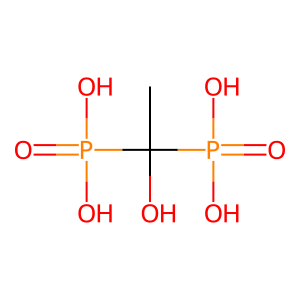

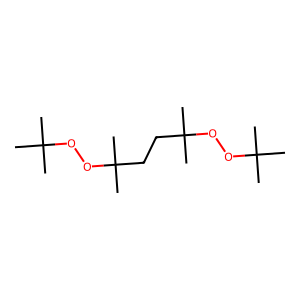

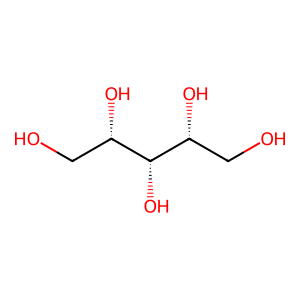

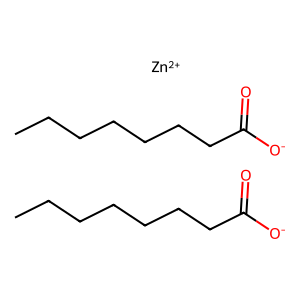

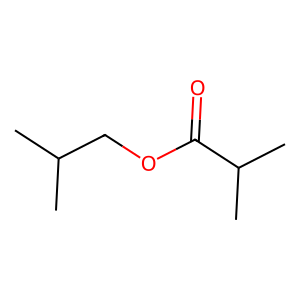

In [6]:
# do some EDA based on the dataframes

# check for missing values
print("Missing values in training set:")
print(train_df.isnull().sum())
print("Missing values in validation set:")
print(valid_df.isnull().sum())
print("Missing values in test set:")
print(test_df.isnull().sum())

# distribution of labels for each task
for task in tasks:
    print(f"Label distribution for task {task} in training set:")
    print(train_df[task].value_counts(dropna=False))
    print(f"Label distribution for task {task} in validation set:")
    print(valid_df[task].value_counts(dropna=False))
    print(f"Label distribution for task {task} in test set:")
    print(test_df[task].value_counts(dropna=False))

# visualize some molecules
print("Sample molecules from training set:")
for smi in train_df['ids'].head(5):
    mol = Chem.MolFromSmiles(smi)
    display(Chem.Draw.MolToImage(mol))

 Added 'No-finding' column — 4070 samples marked as 'no finding'.
 Added 'No-finding' column — 443 samples marked as 'no finding'.
 Added 'No-finding' column — 441 samples marked as 'no finding'.


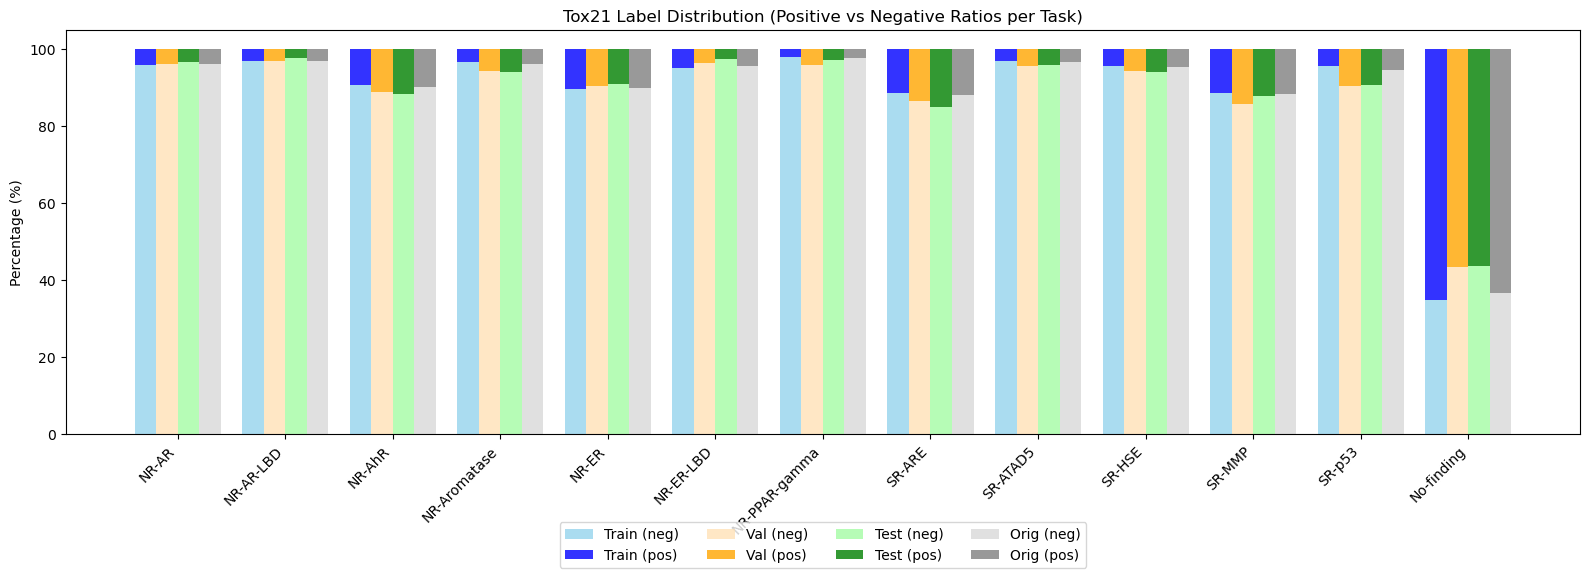

Task | Train(+) | Val(+) | Test(+) | Orig(+)
--------------------------------------------------------------------------------
NR-AR           |   3.99% |   3.96% |   3.45% |   3.94%
NR-AR-LBD       |   3.08% |   3.20% |   2.43% |   3.03%
NR-AhR          |   9.41% |  11.13% |  11.75% |   9.82%
NR-Aromatase    |   3.32% |   5.75% |   6.00% |   3.83%
NR-ER           |  10.32% |   9.59% |   8.94% |  10.11%
NR-ER-LBD       |   4.78% |   3.71% |   2.68% |   4.46%
NR-PPAR-gamma   |   2.11% |   4.09% |   2.81% |   2.38%
SR-ARE          |  11.47% |  13.55% |  15.07% |  12.04%
SR-ATAD5        |   3.13% |   4.48% |   4.21% |   3.37%
SR-HSE          |   4.49% |   5.63% |   6.00% |   4.76%
SR-MMP          |  11.36% |  14.19% |  12.26% |  11.73%
SR-p53          |   4.41% |   9.59% |   9.20% |   5.41%
No-finding      |  65.04% |  56.65% |  56.32% |  63.33%


In [7]:
# # do some visualizations of label distributions in the same plot
# import matplotlib.pyplot as plt
# import seaborn as sns
# for task in tasks:
#     plt.figure(figsize=(12, 4))
#     sns.countplot(x=task, data=train_df, label='Train', color='blue', alpha=0.5)
#     sns.countplot(x=task, data=valid_df, label='Valid', color='orange', alpha=0.5)
#     sns.countplot(x=task, data=test_df, label='Test', color='green', alpha=0.5)
#     plt.title(f"Label Distribution for Task {task}")
#     plt.legend()
#     plt.show()


import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd

def add_no_finding_label(df, tasks, label_name="No-finding"):
    """
    Adds a binary column indicating if the molecule has *no positive labels*
    across all Tox21 tasks.

    Args:
        df (pd.DataFrame): Input DataFrame containing task columns.
        tasks (list[str]): List of Tox21 task column names.
        label_name (str): Name of the new label column.
    Returns:
        pd.DataFrame: Updated DataFrame with an extra 'No-finding' column.
    """
    # Treat NaN as 0 (unlabeled)
    task_vals = df[tasks].fillna(0).values
    # 1 if all 0 across tasks → no positive findings
    no_finding = (np.sum(task_vals, axis=1) == 0).astype(int)
    df[label_name] = no_finding
    print(f" Added '{label_name}' column — {df[label_name].sum()} samples marked as 'no finding'.")
    return df


def show_split_distribution_tox21_stacked(train_df, val_df, test_df, tasks, original_df=None, save_name="tox21_label_distribution_stacked.png"):
    """
    Visualize Tox21 label distributions (positive vs negative) across train/val/test/original datasets as stacked bars.

    Each task will show bars indicating the proportion of positive (1) and negative (0) samples per split.

    Args:
        train_df (pd.DataFrame): Training set with binary task columns.
        val_df (pd.DataFrame): Validation set.
        test_df (pd.DataFrame): Test set.
        tasks (list[str]): List of Tox21 task column names.
        original_df (pd.DataFrame, optional): Original dataset for comparison.
        save_name (str): Output filename for the figure.
    """
    def compute_ratios(df):
        """Compute positive and negative ratios per task (percentage)."""
        pos_ratio = []
        neg_ratio = []
        for t in tasks:
            valid = df[t].notna()
            if valid.sum() == 0:
                pos_ratio.append(0)
                neg_ratio.append(0)
                continue
            pos = df.loc[valid, t].sum()
            total = valid.sum()
            pos_ratio.append((pos / total) * 100)
            neg_ratio.append(100 - (pos / total) * 100)
        return pos_ratio, neg_ratio

    # Compute ratios for each split
    train_pos, train_neg = compute_ratios(train_df)
    val_pos, val_neg     = compute_ratios(val_df)
    test_pos, test_neg   = compute_ratios(test_df)
    if original_df is not None:
        orig_pos, orig_neg = compute_ratios(original_df)

    # Plot
    plt.figure(figsize=(16, 6))
    x = np.arange(len(tasks))
    width = 0.2

    # Stack positive (bottom=negative)
    plt.bar(x - width*1.5, train_neg, width, label='Train (neg)', color='skyblue', alpha=0.7)
    plt.bar(x - width*1.5, train_pos, width, bottom=train_neg, label='Train (pos)', color='blue', alpha=0.8)

    plt.bar(x - width/2, val_neg, width, label='Val (neg)', color='navajowhite', alpha=0.7)
    plt.bar(x - width/2, val_pos, width, bottom=val_neg, label='Val (pos)', color='orange', alpha=0.8)

    plt.bar(x + width/2, test_neg, width, label='Test (neg)', color='palegreen', alpha=0.7)
    plt.bar(x + width/2, test_pos, width, bottom=test_neg, label='Test (pos)', color='green', alpha=0.8)

    if original_df is not None:
        plt.bar(x + width*1.5, orig_neg, width, label='Orig (neg)', color='lightgrey', alpha=0.7)
        plt.bar(x + width*1.5, orig_pos, width, bottom=orig_neg, label='Orig (pos)', color='grey', alpha=0.8)

    plt.ylabel("Percentage (%)")
    plt.title("Tox21 Label Distribution (Positive vs Negative Ratios per Task)")
    plt.xticks(x, tasks, rotation=45, ha='right')
    plt.legend(ncol=4, bbox_to_anchor=(0.5, -0.2), loc='upper center')
    plt.tight_layout()

    # Save
    save_dir = "imgs"
    os.makedirs(save_dir, exist_ok=True)
    save_path = osp.join(save_dir, save_name)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    # Print numeric summary
    print("Task | Train(+) | Val(+) | Test(+) " + ("| Orig(+)" if original_df is not None else ""))
    print("-" * (65 if original_df is None else 80))
    for i, t in enumerate(tasks):
        summary = f"{t:<15} | {train_pos[i]:6.2f}% | {val_pos[i]:6.2f}% | {test_pos[i]:6.2f}%"
        if original_df is not None:
            summary += f" | {orig_pos[i]:6.2f}%"
        print(summary)

tasks = [
    "NR-AR", "NR-AR-LBD", "NR-AhR", "NR-Aromatase",
    "NR-ER", "NR-ER-LBD", "NR-PPAR-gamma",
    "SR-ARE", "SR-ATAD5", "SR-HSE", "SR-MMP", "SR-p53"
]

# Add a split column before stacking (for traceability)
train_df['split'] = 'train'
valid_df['split'] = 'valid'
test_df['split']  = 'test'

train_df = add_no_finding_label(train_df, tasks)
valid_df = add_no_finding_label(valid_df, tasks)
test_df  = add_no_finding_label(test_df,  tasks)
# Update your task list if you want to include it in visualizations:
tasks_with_no = tasks + ["No-finding"]

# Stack them together
tox21_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

# Optional: reorder columns so 'split' is first for clarity
cols = ['split'] + [c for c in tox21_df.columns if c != 'split']
tox21_df = tox21_df[cols]

show_split_distribution_tox21_stacked(train_df, valid_df, test_df, tasks_with_no, original_df=tox21_df)

### Stratified, Round-Robin, Rare-First Sampling

Held out existing test set with 783 samples.
Stratified Split: Train=6273, Val=767, Test=783
Held out fixed test set (783 samples).
 Balanced Split: Train=6258, Val=782, Test=783
 Held out 783 samples for test.
 Rare-first Split: Train=6258, Val=782, Test=783


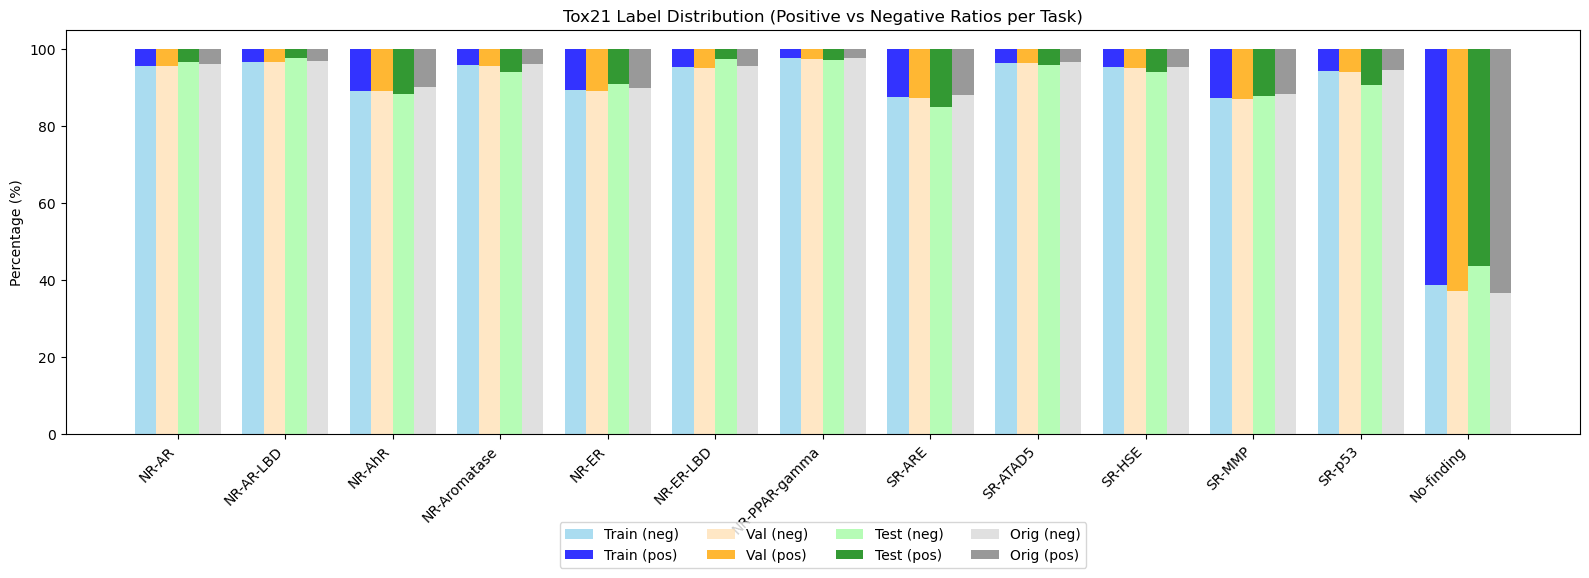

Task | Train(+) | Val(+) | Test(+) | Orig(+)
--------------------------------------------------------------------------------
NR-AR           |   4.27% |   4.43% |   3.45% |   3.94%
NR-AR-LBD       |   3.24% |   3.26% |   2.43% |   3.03%
NR-AhR          |  10.76% |  10.95% |  11.75% |   9.82%
NR-Aromatase    |   4.14% |   4.30% |   6.00% |   3.83%
NR-ER           |  10.66% |  10.95% |   8.94% |  10.11%
NR-ER-LBD       |   4.73% |   4.82% |   2.68% |   4.46%
NR-PPAR-gamma   |   2.41% |   2.48% |   2.81% |   2.38%
SR-ARE          |  12.51% |  12.78% |  15.07% |  12.04%
SR-ATAD5        |   3.51% |   3.52% |   4.21% |   3.37%
SR-HSE          |   4.77% |   4.82% |   6.00% |   4.76%
SR-MMP          |  12.61% |  12.91% |  12.26% |  11.73%
SR-p53          |   5.75% |   5.87% |   9.20% |   5.41%
No-finding      |  61.39% |  62.71% |  56.32% |  63.33%


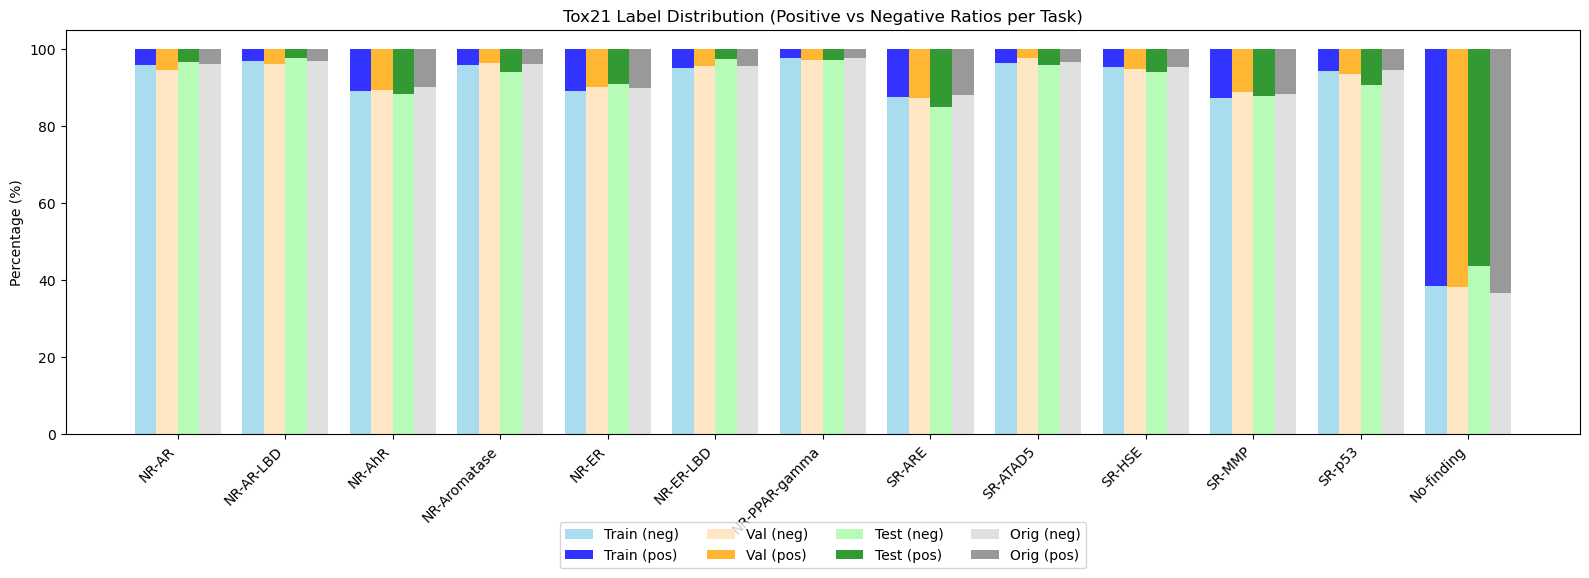

Task | Train(+) | Val(+) | Test(+) | Orig(+)
--------------------------------------------------------------------------------
NR-AR           |   4.15% |   5.37% |   3.45% |   3.94%
NR-AR-LBD       |   3.15% |   3.96% |   2.43% |   3.03%
NR-AhR          |  10.82% |  10.49% |  11.75% |   9.82%
NR-Aromatase    |   4.22% |   3.71% |   6.00% |   3.83%
NR-ER           |  10.80% |   9.85% |   8.94% |  10.11%
NR-ER-LBD       |   4.79% |   4.35% |   2.68% |   4.46%
NR-PPAR-gamma   |   2.35% |   2.94% |   2.81% |   2.38%
SR-ARE          |  12.53% |  12.66% |  15.07% |  12.04%
SR-ATAD5        |   3.64% |   2.43% |   4.21% |   3.37%
SR-HSE          |   4.71% |   5.24% |   6.00% |   4.76%
SR-MMP          |  12.82% |  11.25% |  12.26% |  11.73%
SR-p53          |   5.67% |   6.52% |   9.20% |   5.41%
No-finding      |  61.49% |  61.89% |  56.32% |  63.33%


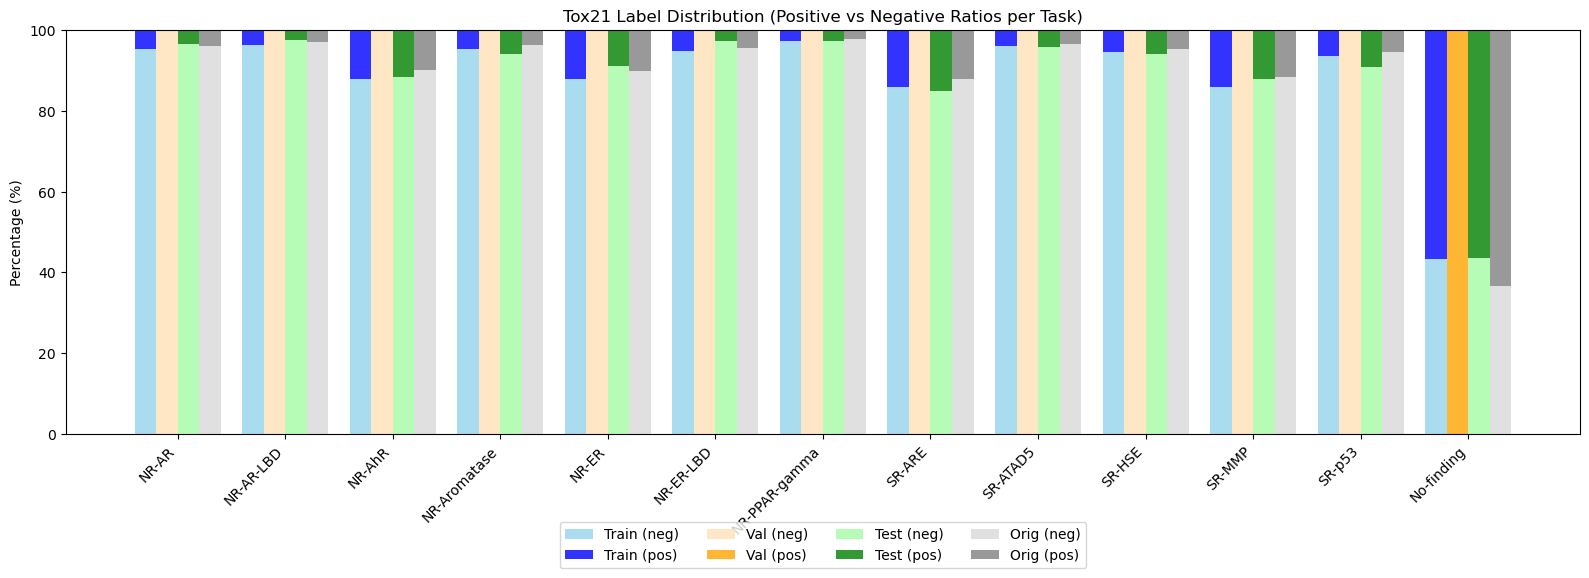

Task | Train(+) | Val(+) | Test(+) | Orig(+)
--------------------------------------------------------------------------------
NR-AR           |   4.83% |   0.00% |   3.45% |   3.94%
NR-AR-LBD       |   3.64% |   0.00% |   2.43% |   3.03%
NR-AhR          |  12.13% |   0.00% |  11.75% |   9.82%
NR-Aromatase    |   4.68% |   0.00% |   6.00% |   3.83%
NR-ER           |  12.03% |   0.00% |   8.94% |  10.11%
NR-ER-LBD       |   5.34% |   0.00% |   2.68% |   4.46%
NR-PPAR-gamma   |   2.72% |   0.00% |   2.81% |   2.38%
SR-ARE          |  14.11% |   0.00% |  15.07% |  12.04%
SR-ATAD5        |   3.95% |   0.00% |   4.21% |   3.37%
SR-HSE          |   5.37% |   0.00% |   6.00% |   4.76%
SR-MMP          |  14.22% |   0.00% |  12.26% |  11.73%
SR-p53          |   6.49% |   0.00% |   9.20% |   5.41%
No-finding      |  56.73% | 100.00% |  56.32% |  63.33%


In [8]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
import random
import pandas as pd
from collections import defaultdict, Counter

def multilabel_split_tox21(
    df,
    tasks,
    train_size=20000,
    val_size=2500,
    test_size=2500,
    seed=42,
    holdout_test_df=None
):
    """
    Stratified multilabel split for Tox21 binary columns with optional held-out test set.
    """
    random.seed(seed)
    df = df.reset_index(drop=True).copy()

    # --- Exclude held-out test set if provided ---
    if holdout_test_df is not None:
        test_df = holdout_test_df.copy()
        heldout_idx = set(test_df.index)
        df = df[~df.index.isin(heldout_idx)].reset_index(drop=True)
        print(f"Held out existing test set with {len(test_df)} samples.")
    else:
        test_df = None

    # Convert to numpy multilabel matrix
    Y = df[tasks].fillna(0).astype(int).values
    total = len(df)
    subsz = train_size + val_size + (0 if test_df is not None else test_size)

    # Stage 1: Train / Val split (since test is held out)
    msss = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        train_size=train_size / subsz,
        test_size=val_size / subsz,
        random_state=seed
    )
    tr_i, val_i = next(msss.split(np.zeros(len(df)), Y))
    train_df = df.iloc[tr_i].reset_index(drop=True)
    val_df = df.iloc[val_i].reset_index(drop=True)

    if test_df is None:
        remain = df.drop(train_df.index.union(val_df.index))
        test_df = remain.sample(n=test_size, random_state=seed).reset_index(drop=True)

    print(f"Stratified Split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    return train_df, val_df, test_df

def multilabel_balanced_split_tox21(
    df,
    tasks,
    train_size=20000,
    val_size=2500,
    test_size=2500,
    seed=42,
    holdout_test_df=None
):
    """
    Round-robin balanced multilabel split for Tox21 binary columns.
    """
    random.seed(seed)
    df = df.reset_index(drop=True).copy()

    if holdout_test_df is not None:
        test_df = holdout_test_df.copy()
        heldout_idx = set(test_df.index)
        df = df[~df.index.isin(heldout_idx)].reset_index(drop=True)
        print(f"Held out fixed test set ({len(test_df)} samples).")
    else:
        test_df = None

    total_size = train_size + val_size + (0 if test_df is not None else test_size)
    label2idxs = defaultdict(list)
    
    # Build mapping: task -> indices where label == 1
    for task in tasks:
        pos_idx = df.index[df[task] == 1].tolist()
        random.shuffle(pos_idx)
        label2idxs[task] = pos_idx

    labels = list(label2idxs.keys())
    label_ptr = {t: 0 for t in labels}
    sampled_idx = set()
    total_idxs = set(df.index)

    # Round-robin sampling
    while len(sampled_idx) < total_size:
        for label in labels:
            ptr = label_ptr[label]
            total_label_idx = label2idxs[label]
            if ptr >= len(total_label_idx):
                continue
            while ptr < len(total_label_idx):
                xi = total_label_idx[ptr]
                ptr += 1
                if xi not in sampled_idx:
                    sampled_idx.add(xi)
                    break
            label_ptr[label] = ptr
        # Stop if all labels exhausted
        if all(label_ptr[t] >= len(label2idxs[t]) for t in labels):
            break

    # Fill missing with negatives if needed
    remaining_needed = total_size - len(sampled_idx)
    if remaining_needed > 0:
        remain_pool = list(total_idxs - sampled_idx)
        random.shuffle(remain_pool)
        sampled_idx.update(remain_pool[:remaining_needed])

    sampled_idx = list(sampled_idx)
    random.shuffle(sampled_idx)

    train_ids = sampled_idx[:train_size]
    val_ids = sampled_idx[train_size:train_size + val_size]

    train_df = df.loc[train_ids].reset_index(drop=True)
    val_df = df.loc[val_ids].reset_index(drop=True)

    if test_df is None:
        remain = df.drop(train_df.index.union(val_df.index))
        test_df = remain.sample(n=test_size, random_state=seed).reset_index(drop=True)

    print(f" Balanced Split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    return train_df, val_df, test_df

def multilabel_rare_first_split_tox21(
    df,
    tasks,
    train_size=20000,
    val_size=2500,
    test_size=2500,
    seed=42,
    holdout_test_df=None
):
    """
    Rare-first multilabel split for Tox21 binary columns with optional held-out test set.
    """
    random.seed(seed)
    df = df.reset_index(drop=True).copy()

    if holdout_test_df is not None:
        test_df = holdout_test_df.copy()
        heldout_idx = set(test_df.index)
        df = df[~df.index.isin(heldout_idx)].reset_index(drop=True)
        print(f" Held out {len(test_df)} samples for test.")
    else:
        test_df = None

    # Count positives per label
    label_counts = {t: int(df[t].fillna(0).sum()) for t in tasks}
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1])  # rare → common

    # Build mapping of task → indices with label == 1
    label2idxs = {t: df.index[df[t] == 1].tolist() for t in tasks}
    for idx_list in label2idxs.values():
        random.shuffle(idx_list)

    train_idx, val_idx, used_idx = set(), set(), set()
    total_needed = train_size + val_size + (0 if test_df is not None else test_size)

    for task, _ in sorted_labels:
        available = [i for i in label2idxs[task] if i not in used_idx]
        random.shuffle(available)
        for i in available:
            if len(train_idx) < train_size:
                train_idx.add(i)
            elif len(val_idx) < val_size:
                val_idx.add(i)
            used_idx.add(i)
            if len(train_idx) + len(val_idx) >= total_needed:
                break
        if len(train_idx) + len(val_idx) >= total_needed:
            break

    # Fill remaining from unassigned samples
    remaining = list(set(df.index) - used_idx)
    random.shuffle(remaining)
    for i in remaining:
        if len(train_idx) < train_size:
            train_idx.add(i)
        elif len(val_idx) < val_size:
            val_idx.add(i)

    train_df = df.loc[list(train_idx)].reset_index(drop=True)
    val_df = df.loc[list(val_idx)].reset_index(drop=True)

    if test_df is None:
        remain = list(set(df.index) - train_idx - val_idx)
        random.shuffle(remain)
        test_df = df.loc[remain[:test_size]].reset_index(drop=True)

    print(f" Rare-first Split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    return train_df, val_df, test_df



strat_train_df, strat_valid_df, strat_test_df=  multilabel_split_tox21(tox21_df, tasks_with_no, len(train_df), len(valid_df), len(test_df), holdout_test_df=test_df)
bal_train_df, bal_valid_df, bal_test_df=  multilabel_balanced_split_tox21(tox21_df,tasks_with_no, len(train_df), len(valid_df), len(test_df), holdout_test_df=test_df)
rare_train_df, rare_valid_df, rare_test_df=  multilabel_rare_first_split_tox21(tox21_df,tasks_with_no, len(train_df), len(valid_df), len(test_df), holdout_test_df=test_df)

show_split_distribution_tox21_stacked(strat_train_df, strat_valid_df, strat_test_df, tasks_with_no, original_df=tox21_df)
show_split_distribution_tox21_stacked(bal_train_df, bal_valid_df, bal_test_df, tasks_with_no, original_df=tox21_df)
show_split_distribution_tox21_stacked(rare_train_df, rare_valid_df, rare_test_df, tasks_with_no, original_df=tox21_df)

### Extract molecular features for training basic machine learning models.

In [9]:
# extract molecular features using RDKit and save to CSV files
def featurize_molecule(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    features = {}
    # Basic descriptors
    features['MolWt'] = Descriptors.MolWt(mol)
    features['NumHDonors'] = Descriptors.NumHDonors(mol)
    features['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
    features['TPSA'] = Descriptors.TPSA(mol)
    features['LogP'] = Descriptors.MolLogP(mol)
    # MACCS keys
    maccs = MACCSkeys.GenMACCSKeys(mol)
    for i in range(167):
        features[f'MACCS_{i}'] = int(maccs.GetBit(i))
    # Morgan fingerprint
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    for i in range(2048):
        features[f'Morgan_{i}'] = int(morgan_fp.GetBit(i))
    return features

def featurize_dataset(df):
    feature_list = []
    for smi in tqdm(df['ids'], desc="Featurizing molecules"):
        feats = featurize_molecule(smi)
        if feats is not None:
            feature_list.append(feats)
        else:
            feature_list.append({})  # Append empty dict for invalid SMILES
    features_df = pd.DataFrame(feature_list)
    return pd.concat([df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

train_features_df = featurize_dataset(train_df)
valid_features_df = featurize_dataset(valid_df)
test_features_df = featurize_dataset(test_df)

strat_feat_train_df, strat_feat_valid_df, strat_feat_test_df=  featurize_dataset(strat_train_df), featurize_dataset(strat_valid_df), featurize_dataset(strat_test_df)
bal_feat_train_df, bal_feat_valid_df, bal_feat_test_df=  featurize_dataset(bal_train_df), featurize_dataset(bal_valid_df), featurize_dataset(bal_test_df)
rare_feat_train_df, rare_feat_valid_df, rare_feat_test_df=   featurize_dataset(rare_train_df), featurize_dataset(rare_valid_df), featurize_dataset(rare_test_df)



# save featurized data to CSV files
train_features_df.to_csv("tox21_processed/train_featurized.csv", index=False)
valid_features_df.to_csv("tox21_processed/valid_featurized.csv", index=False)   
test_features_df.to_csv("tox21_processed/test_featurized.csv", index=False)

strat_feat_train_df.to_csv("tox21_processed/strat_feat_train_df.csv", index=False)
strat_feat_valid_df.to_csv("tox21_processed/strat_feat_valid_df.csv", index=False)   
strat_feat_test_df.to_csv("tox21_processed/strat_feat_test_df.csv", index=False)

bal_feat_train_df.to_csv("tox21_processed/bal_feat_train_df.csv", index=False)
bal_feat_valid_df.to_csv("tox21_processed/bal_feat_valid_df.csv", index=False)   
bal_feat_test_df.to_csv("tox21_processed/bal_feat_test_df.csv", index=False)

rare_feat_train_df.to_csv("tox21_processed/rare_feat_train_df.csv", index=False)
rare_feat_valid_df.to_csv("tox21_processed/rare_feat_valid_df.csv", index=False)   
rare_feat_test_df.to_csv("tox21_processed/rare_feat_test_df.csv", index=False)

Featurizing molecules:   0%|          | 0/6258 [00:00<?, ?it/s][00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGenerator
[00:25:34] DEPRECATION WARNING: please use MorganGen

In [10]:
# check the new dataframes
print("Featurized training set sample:")
train_features_df.head()

Featurized training set sample:


,X,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,...,Morgan_2038,Morgan_2039,Morgan_2040,Morgan_2041,Morgan_2042,Morgan_2043,Morgan_2044,Morgan_2045,Morgan_2046,Morgan_2047
0,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,<rdkit.Chem.rdchem.Mol object at 0x000001F2AF1...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# do some EDA on the featurized data
print("Featurized training set info:")
print(train_features_df.info())
print("Featurized validation set info:")
print(valid_features_df.info())
print("Featurized test set info:")
print(test_features_df.info())
print("✅ Featurization complete.")

Featurized training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Columns: 2248 entries, X to Morgan_2047
dtypes: float64(27), int32(1), int64(2217), object(3)
memory usage: 107.3+ MB
None
Featurized validation set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Columns: 2248 entries, X to Morgan_2047
dtypes: float64(27), int32(1), int64(2217), object(3)
memory usage: 13.4+ MB
None
Featurized test set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Columns: 2248 entries, X to Morgan_2047
dtypes: float64(27), int32(1), int64(2217), object(3)
memory usage: 13.4+ MB
None
✅ Featurization complete.


In [12]:
# print the object type columns to verify
print(train_features_df.select_dtypes(include=['object']).columns)

Index(['X', 'ids', 'split'], dtype='object')


In [13]:
#check for any remaining missing values
print("Missing values in featurized training set:")
print(train_features_df.isnull().sum().sum())
print("Missing values in featurized validation set:")
print(valid_features_df.isnull().sum().sum())
print("Missing values in featurized test set:")
print(test_features_df.isnull().sum().sum())

Missing values in featurized training set:
0
Missing values in featurized validation set:
0
Missing values in featurized test set:
0


In [14]:
# normalize continuous features
from sklearn.preprocessing import StandardScaler
continuous_features = ['MolWt', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'LogP']
scaler = StandardScaler()
train_features_df[continuous_features] = scaler.fit_transform(train_features_df[continuous_features])
valid_features_df[continuous_features] = scaler.transform(valid_features_df[continuous_features])
test_features_df[continuous_features] = scaler.transform(test_features_df[continuous_features])


scaler = StandardScaler()
strat_feat_train_df[continuous_features] , strat_feat_valid_df[continuous_features] , strat_feat_test_df[continuous_features] =  scaler.fit_transform(strat_feat_train_df[continuous_features]), scaler.transform(strat_feat_valid_df[continuous_features]),   scaler.transform(strat_feat_test_df[continuous_features])

scaler = StandardScaler()
bal_feat_train_df[continuous_features] , bal_feat_valid_df[continuous_features] , bal_feat_test_df[continuous_features] = scaler.fit_transform(bal_feat_train_df[continuous_features]), scaler.transform(bal_feat_valid_df[continuous_features]),   scaler.transform(bal_feat_test_df[continuous_features])

scaler = StandardScaler()
rare_feat_train_df[continuous_features] , rare_feat_valid_df[continuous_features] , rare_feat_test_df[continuous_features] =  scaler.fit_transform(rare_feat_train_df[continuous_features]), scaler.transform(rare_feat_valid_df[continuous_features]),   scaler.transform(rare_feat_test_df[continuous_features])


print("✅ Normalization complete.")

✅ Normalization complete.


In [15]:
# save normalized data to CSV files
train_features_df.to_csv("tox21_processed/train_normalized.csv", index=False)
valid_features_df.to_csv("tox21_processed/valid_normalized.csv", index=False)
test_features_df.to_csv("tox21_processed/test_normalized.csv", index=False)


strat_feat_train_df.to_csv("tox21_processed/strat_normalized_train_df.csv", index=False)
strat_feat_valid_df.to_csv("tox21_processed/strat_normalized_valid_df.csv", index=False)   
strat_feat_test_df.to_csv("tox21_processed/strat_normalized_test_df.csv", index=False)

bal_feat_train_df.to_csv("tox21_processed/bal_normalized_train_df.csv", index=False)
bal_feat_valid_df.to_csv("tox21_processed/bal_normalized_valid_df.csv", index=False)   
bal_feat_test_df.to_csv("tox21_processed/bal_normalized_test_df.csv", index=False)

rare_feat_train_df.to_csv("tox21_processed/rare_normalized_train_df.csv", index=False)
rare_feat_valid_df.to_csv("tox21_processed/rare_normalized_valid_df.csv", index=False)   
rare_feat_test_df.to_csv("tox21_processed/rare_normalized_test_df.csv", index=False)

print("✅ Data processing pipeline complete. Processed files saved in 'tox21_processed' directory.")

✅ Data processing pipeline complete. Processed files saved in 'tox21_processed' directory.


In [16]:
# train a simple model to verify the pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
X_train = train_features_df[continuous_features + [col for col in train_features_df.columns if col.startswith('MACCS_') or col.startswith('Morgan_')]]
y_train = train_features_df[tasks].fillna(0).astype(int)
X_valid = valid_features_df[continuous_features + [col for col in valid_features_df.columns if col.startswith('MACCS_') or col.startswith('Morgan_')]]
y_valid = valid_features_df[tasks].fillna(0).astype(int)
X_test = test_features_df[continuous_features + [col for col in test_features_df.columns if col.startswith('MACCS_') or col.startswith('Morgan_')]]
y_test = test_features_df[tasks].fillna(0).astype(int)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification report on test set:")
print(classification_report(y_test, y_pred, zero_division=0))

print("✅ Model training and evaluation complete.")

Classification report on test set:
              precision    recall  f1-score   support

           0       0.90      0.33      0.49        27
           1       0.67      0.21      0.32        19
           2       0.64      0.10      0.17        92
           3       0.67      0.04      0.08        47
           4       0.62      0.07      0.13        70
           5       0.50      0.14      0.22        21
           6       0.00      0.00      0.00        22
           7       0.50      0.03      0.06       118
           8       0.00      0.00      0.00        33
           9       1.00      0.02      0.04        47
          10       0.56      0.05      0.10        96
          11       0.67      0.03      0.05        72

   micro avg       0.65      0.07      0.12       664
   macro avg       0.56      0.09      0.14       664
weighted avg       0.59      0.07      0.11       664
 samples avg       0.03      0.02      0.02       664

✅ Model training and evaluation complete.


In [17]:
# which model is better for multi-label classification?
# try XGBoost, LightGBM, and a simple neural network

# try XGBoost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)
print("XGBoost Classification report on test set:")
print(classification_report(y_test, y_xgb_pred, zero_division=0))
# calculate roc_auc_score for each task
from sklearn.metrics import roc_auc_score
for i, task in enumerate(tasks):
    try:
        auc = roc_auc_score(y_test[task], y_xgb_pred[:, i])
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")
        continue
print("✅ XGBoost model training and evaluation complete.")

c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\xgboost\training.py:199: UserWarning: [00:28:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification report on test set:
              precision    recall  f1-score   support

           0       0.73      0.30      0.42        27
           1       0.60      0.16      0.25        19
           2       0.37      0.21      0.26        92
           3       0.47      0.19      0.27        47
           4       0.45      0.14      0.22        70
           5       0.38      0.14      0.21        21
           6       0.00      0.00      0.00        22
           7       0.38      0.10      0.16       118
           8       0.00      0.00      0.00        33
           9       0.50      0.15      0.23        47
          10       0.49      0.23      0.31        96
          11       0.78      0.10      0.17        72

   micro avg       0.44      0.15      0.22       664
   macro avg       0.43      0.14      0.21       664
weighted avg       0.45      0.15      0.22       664
 samples avg       0.08      0.06      0.06       664

ROC AUC for task NR-AR: 0.6462
ROC A

In [18]:
# try a simple neural network
import torch.nn as nn
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
nn_model = SimpleNN(input_dim, output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
# convert data to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# train the neural network
num_epochs = 20
for epoch in range(num_epochs):
    nn_model.train()
    optimizer.zero_grad()
    outputs = nn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
# evaluate the neural network
nn_model.eval()
with torch.no_grad():
    y_nn_pred = nn_model(X_test_tensor)
    y_nn_pred = (y_nn_pred.numpy() > 0.5).astype(int)
print("Neural Network Classification report on test set:")
print(classification_report(y_test, y_nn_pred, zero_division=0))
# calculate roc_auc_score for each task
for i, task in enumerate(tasks):
    try:
        auc = roc_auc_score(y_test[task], y_nn_pred[:, i])
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")
        continue
    
print("✅ Neural Network model training and evaluation complete.")

Epoch [5/20], Loss: 0.6186
Epoch [10/20], Loss: 0.4018
Epoch [15/20], Loss: 0.2742
Epoch [20/20], Loss: 0.2873
Neural Network Classification report on test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        92
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00        70
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00        22
           7       0.00      0.00      0.00       118
           8       0.00      0.00      0.00        33
           9       0.00      0.00      0.00        47
          10       0.00      0.00      0.00        96
          11       0.00      0.00      0.00        72

   micro avg       0.00      0.00      0.00       664
   macro avg       0.00      0.00      0.00       664
weighted avg       0.00    

### Extract graph features for training graph machine learning models.

In [ ]:
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import AllChem
import torch

# Tox21 assay textual descriptions
ASSAY_DESCRIPTIONS = {
    "NR-AR": "Androgen receptor activation assay for endocrine disruption.",
    "NR-AR-LBD": "Assay for ligand binding to the androgen receptor’s ligand-binding domain.",
    "NR-AhR": "Aryl hydrocarbon receptor activation assay detecting xenobiotic signaling.",
    "NR-Aromatase": "Aromatase enzyme inhibition assay for estrogen synthesis interference.",
    "NR-ER": "Estrogen receptor activation assay for endocrine modulation.",
    "NR-ER-LBD": "Ligand-binding domain assay for estrogen receptor activation/inhibition.",
    "NR-PPAR-gamma": "Peroxisome proliferator-activated receptor gamma activation assay for metabolic regulation.",
    "SR-ARE": "Antioxidant response element reporter assay for oxidative stress response.",
    "SR-ATAD5": "ATAD5-luciferase reporter assay for DNA damage and genomic stress.",
    "SR-HSE": "Heat shock element activation assay for protein misfolding stress response.",
    "SR-MMP": "Mitochondrial membrane potential assay measuring mitochondrial dysfunction.",
    "SR-p53": "p53 reporter assay for genotoxic and stress-induced DNA damage response."
}


# convert data to graph format for graph neural networks
def mol_to_graph_data_obj(mol, df, tasks=tasks):
    if mol is None:
        return None
    # node features
    atom_features_list = []

    # ensure molecule has 3D conformer
    if mol.GetNumConformers() == 0:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())
        AllChem.UFFOptimizeMolecule(mol)
    conf = mol.GetConformer()
    coords = [] 
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        coords.append([pos.x, pos.y, pos.z])
    pos = torch.tensor(coords, dtype=torch.float)


    for atom in mol.GetAtoms():
        atom_features = []
        atom_features.append(atom.GetAtomicNum())
        atom_features.append(atom.GetDegree())
        atom_features.append(atom.GetFormalCharge())
        atom_features.append(atom.GetHybridization())
        atom_features.append(int(atom.GetIsAromatic()))
        atom_features_list.append(atom_features)

    # standardize node features to tensor
    x = torch.tensor(atom_features_list, dtype=torch.float)

    # edge index and edge features
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))
        bond_type = bond.GetBondType()
        if bond_type == Chem.rdchem.BondType.SINGLE:
            edge_attr.append([1, 0, 0])
            edge_attr.append([1, 0, 0])
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            edge_attr.append([0, 1, 0])
            edge_attr.append([0, 1, 0])
        elif bond_type == Chem.rdchem.BondType.TRIPLE:
            edge_attr.append([0, 0, 1])
            edge_attr.append([0, 0, 1])
        else:
            edge_attr.append([0, 0, 0])
            edge_attr.append([0, 0, 0])
    if len(edge_index) > 0:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,pos=pos, positive_texts=None, negative_texts=None)
    
    # add the corresponding labels as y
    smi = Chem.MolToSmiles(mol)
    labels = df[df['ids'] == smi][tasks].values
    if len(labels) > 0:
        data.y = torch.tensor(labels[0], dtype=torch.float)
    else:
        data.y = torch.tensor([float('nan')] * len(tasks), dtype=torch.float)

    return data

def featurize_graph_dataset(df, tasks=tasks):
    graph_list = []
    for smi in tqdm(df['ids'], desc="Featurizing molecules to graphs"):
        mol = Chem.MolFromSmiles(smi)
        graph = mol_to_graph_data_obj(mol, df, tasks=tasks)

        # get label row for this molecule
        row = df[df['ids'] == smi][tasks].values
        if len(row) == 0:
            continue
        row = row[0]

        # collect text descriptions
        positive_texts = []
        negative_texts = []
        for i, t in enumerate(tasks):
            if row[i] == 1:
                graph.positive_texts = positive_texts.append(ASSAY_DESCRIPTIONS[t])
            else:
                # random negative: pick a different assay
                neg_choices = [desc for k, desc in ASSAY_DESCRIPTIONS.items() if k != t]
                negative_texts.append(random.choice(neg_choices))
        graph_list.append(graph)
    return graph_list

train_graphs = featurize_graph_dataset(train_df)
valid_graphs = featurize_graph_dataset(valid_df)
test_graphs = featurize_graph_dataset(test_df)

strat_train_graphs = featurize_graph_dataset(strat_feat_train_df, tasks = tasks_with_no)
strat_valid_graphs = featurize_graph_dataset(strat_feat_valid_df, tasks = tasks_with_no)
strat_test_graphs = featurize_graph_dataset(strat_feat_test_df, tasks = tasks_with_no)

bal_train_graphs = featurize_graph_dataset(bal_train_df, tasks = tasks_with_no)
bal_valid_graphs = featurize_graph_dataset(bal_valid_df, tasks = tasks_with_no)
bal_test_graphs = featurize_graph_dataset(bal_test_df, tasks = tasks_with_no)

rare_train_graphs = featurize_graph_dataset(rare_train_df, tasks = tasks_with_no)
rare_valid_graphs = featurize_graph_dataset(rare_valid_df, tasks = tasks_with_no)
rare_test_graphs = featurize_graph_dataset(rare_test_df, tasks = tasks_with_no)

print(f"Number of training graphs: {len(train_graphs)}")
print(f"Number of validation graphs: {len(valid_graphs)}")
print(f"Number of test graphs: {len(test_graphs)}")
print("Sample graph data object:")
print(train_graphs[0])

# first test one molecule
# smi = train_df['ids'].iloc[0]
# mol = Chem.MolFromSmiles(smi)
# graph = mol_to_graph_data_obj(mol)
# print("Sample graph data object:")
# print(graph)

Featurizing molecules to graphs: 100%|██████████| 783/783 [00:01<00:00, 469.14it/s]

Number of training graphs: 6258
Number of validation graphs: 782
Number of test graphs: 783
Sample graph data object:
Data(x=[11, 5], edge_index=[2, 20], edge_attr=[20, 3], y=[12])


In [20]:
# print(train_graphs[138].y)

In [21]:
from rdkit import Chem
from rdkit.Chem import Draw
import torch

# pick one molecule and its graph
idx = 138
mol = Chem.MolFromSmiles(train_df['ids'].iloc[idx])
graph = train_graphs[idx]

# extract label
label_value = graph.y.item() if graph.y.numel() == 1 else graph.y.tolist()
print("Label(s):", label_value)

# draw with RDKit
img = Draw.MolToImage(mol, size=(300, 300), legend=f"Label: {label_value}")
img.show()

Label(s): [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


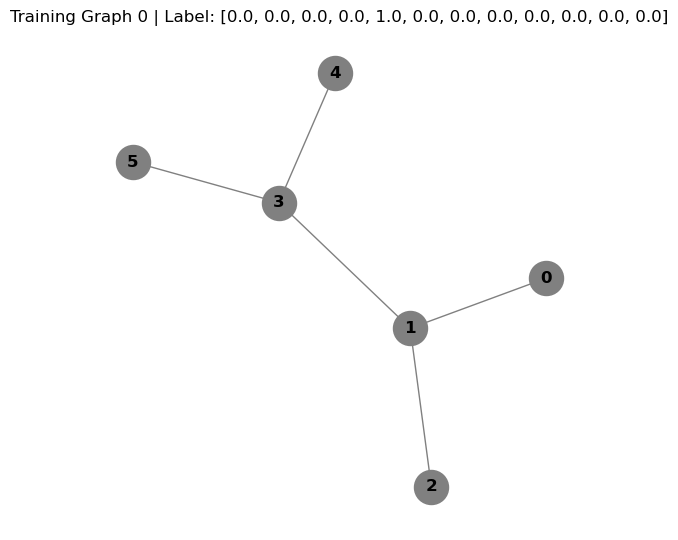

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph_by_label(data, title_prefix="Graph"):
    G = to_networkx(data, to_undirected=True)

    # get label
    if data.y.numel() == 1:
        label = data.y.item()
    else:
        label = data.y.tolist()

    # choose color based on label
    if isinstance(label, (int, float)):
        color = "red" if label > 0.5 else "blue"  # binary coloring
    else:
        color = "gray"

    plt.figure(figsize=(5, 5))
    nx.draw(
        G,
        with_labels=True,
        node_color=color,
        edge_color="gray",
        node_size=600,
        font_weight="bold",
    )
    plt.title(f"{title_prefix} | Label: {label}")
    plt.show()

# Example
visualize_graph_by_label(train_graphs[138], title_prefix="Training Graph 0")

In [23]:
train_graphs[138]

Data(x=[6, 5], edge_index=[2, 10], edge_attr=[10, 3], y=[12])

In [24]:
# save graph data objects using torch.save
torch.save(train_graphs, "tox21_processed/train_graphs.pt")
torch.save(valid_graphs, "tox21_processed/valid_graphs.pt")
torch.save(test_graphs, "tox21_processed/test_graphs.pt")

torch.save(strat_train_graphs, "tox21_processed/strat_train_graphs.pt")
torch.save(strat_valid_graphs, "tox21_processed/strat_valid_graphs.pt")
torch.save(strat_test_graphs, "tox21_processed/strat_test_graphs.pt")

torch.save(bal_train_graphs, "tox21_processed/bal_train_graphs.pt")
torch.save(bal_valid_graphs, "tox21_processed/bal_valid_graphs.pt")
torch.save(bal_test_graphs, "tox21_processed/bal_test_graphs.pt")

torch.save(rare_train_graphs, "tox21_processed/rare_train_graphs.pt")
torch.save(rare_valid_graphs, "tox21_processed/rare_valid_graphs.pt")
torch.save(rare_test_graphs, "tox21_processed/rare_test_graphs.pt")

print("✅ Graph featurization complete and saved.")

✅ Graph featurization complete and saved.


In [25]:
# train a simple GNN to verify the graph pipeline
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = torch.sigmoid(self.fc(x))
        return x
input_dim = train_graphs[0].x.shape[1]
hidden_dim = 64
output_dim = len(tasks)
gnn_model = GNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
# prepare data loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)
# train the GNN
num_epochs = 20
for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for batch_idx ,data in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = gnn_model(data)
        # reshape data.y to [batch_size, num_tasks]
        y = data.y.view(outputs.shape)
        # Clamp y to [0, 1] to avoid BCELoss error
        # y = torch.clamp(y, 0, 1)
        # y = torch.nan_to_num(y, nan=1)
        mask = ~torch.isnan(y)  
        loss = criterion(outputs[mask], y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

y_gnn_pred_list, y_gnn_true_list, valid_mask_list = [], [], []

gnn_model.eval()
with torch.no_grad():
    for data in test_loader:
        outputs = gnn_model(data).cpu()  # (num_graphs_in_batch, output_dim)
        y = data.y.cpu().float()

        # --- reshape y per graph ---
        y = y.view(data.num_graphs, -1)

        # --- align lengths ---
        pad_len = outputs.shape[1] - y.shape[1]
        if pad_len > 0:
            y = torch.cat([y, torch.full((y.shape[0], pad_len), float('nan'))], dim=1)
        elif pad_len < 0:
            outputs = torch.cat([outputs, torch.zeros((outputs.shape[0], -pad_len))], dim=1)

        mask = ~torch.isnan(y)
        y = torch.nan_to_num(y, nan=0.0)

        y_gnn_true_list.append(y)
        y_gnn_pred_list.append(outputs)
        valid_mask_list.append(mask)

# --- concatenate across batches ---
y_gnn_true = torch.cat(y_gnn_true_list, dim=0)
y_gnn_pred = torch.cat(y_gnn_pred_list, dim=0)
valid_mask = torch.cat(valid_mask_list, dim=0)

# --- convert to numpy ---
y_true_np = y_gnn_true.numpy()
y_pred_np = y_gnn_pred.numpy()
mask_np = valid_mask.numpy()

# --- apply threshold ---
y_pred_bin = (y_pred_np > 0.5).astype(int)

# --- classification report ---
print("GNN Classification report on test set:")
valid_idx = mask_np.sum(axis=0) > 0
print(classification_report(
    y_true_np[:, valid_idx],
    y_pred_bin[:, valid_idx],
    zero_division=0
))

# --- ROC-AUC per task ---
for i, task in enumerate(tasks[:y_true_np.shape[1]]):
    if mask_np[:, i].sum() == 0:
        print(f"ROC AUC for task {task}: Skipped (no valid samples)")
        continue
    try:
        auc = roc_auc_score(
            y_true_np[mask_np[:, i], i],
            y_pred_np[mask_np[:, i], i]
        )
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")

Epoch [5/20], Loss: 0.2035
Epoch [10/20], Loss: 0.2012
Epoch [15/20], Loss: 0.1983
Epoch [20/20], Loss: 0.1954
GNN Classification report on test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        90
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        62
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00       111
           8       0.00      0.00      0.00        31
           9       0.00      0.00      0.00        44
          10       0.00      0.00      0.00        89
          11       0.00      0.00      0.00        65

   micro avg       0.00      0.00      0.00       616
   macro avg       0.00      0.00      0.00       616
weighted avg       0.00      0.00     